24.940038468490286
12.732682987908191
-18.556663619493047
-26.92595055557881


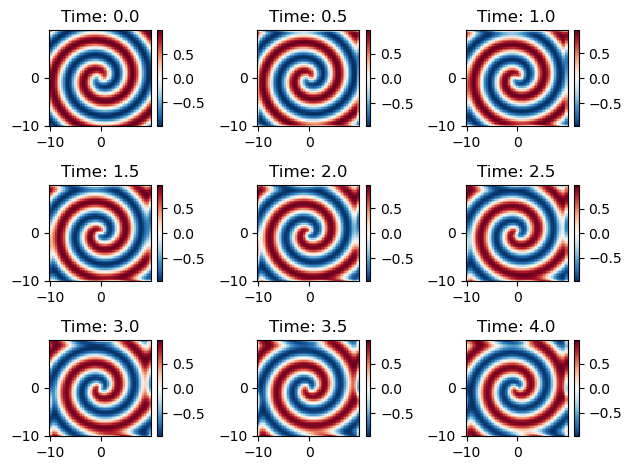

In [1]:
# Joey Roberts - Amath 481 - HW5

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp

#
# Solving 2 coupled odes so we have to stack the vectors of u and v before you put it into
# the solver so fft2 then vector each of them and then stack the vectors
#
# Look at git code 11.3 and 11.6
#

# Define parameters
D1, D2 = 0.1, 0.1
tspan = np.arange(0, 4 + 0.5, 0.5)
beta = 1
T = 4
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
#w = 1 * np.exp(-0.25 * X**2 - Y**2) + 1j * np.zeros((nx, ny))  # Initialize as complex

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

m=1

# Compute u and v
u = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
v = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

# Convert for fourier space
ut = fft2(u)
vt = fft2(v)

uvt0 = np.hstack([(ut.reshape(N)), (vt.reshape(N))])

# Define the ODE system
def spc_rhs(t, uvt, nx, ny, N, K, beta):
    utc = uvt[0:N]
    vtc = uvt[N:]
    utc2 = utc.reshape((nx,ny))
    vtc2 = vtc.reshape((nx,ny))
    u2 = ifft2(utc2)
    v2 = ifft2(vtc2)
    A = u2*u2 + v2*v2
    lam = 1 - A
    ome = -beta*A
    rhs_u = (-D1*K*utc2 + fft2(lam*u2 - ome*v2)).reshape(N)
    rhs_v = (-D2*K*vtc2 + fft2(ome*u2 + lam*v2)).reshape(N)
    rhs = np.hstack([rhs_u, rhs_v])
    return rhs

uvtsol = solve_ivp(spc_rhs, [0,T], uvt0, t_eval=tspan, args=(nx, ny, N, K, beta), method="RK45")

z = uvtsol.y
A1 = z
A1real = A1.real

print(A1real[0,0])
print(A1real[0,1])
print(A1real[1,0])
print(A1real[-1,-1])

for j, t in enumerate(tspan):
    u = np.real(ifft2(z[0:N,j].reshape((nx, ny))))
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, u, cmap = 'RdBu_r')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [24]:
# Define parameters
def cheb(N):
	if N==0: 
		D = 0.; x = 1.
	else:
		n = np.arange(0,N+1)
		x = np.cos(np.pi*n/N).reshape(N+1,1) 
		c = (np.hstack(( [2.], np.ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
		X = np.tile(x,(1,N+1))
		dX = X - X.T
		D = np.dot(c,1./c.T)/(dX+np.eye(N+1))
		D -= np.diag(np.sum(D.T,axis=0))
	return D, x.reshape(N+1)

N = 30
D, x = cheb(N)
D[N,:] = 0
D[0,:] = 0
Dxx = (np.dot(D, D))/((20/2)**2)
y = x
N2 = (N + 1)*(N + 1)
I = np.eye(len(Dxx))
L = np.kron(I, Dxx) + np.kron(Dxx, I)
X, Y = np.meshgrid(x, y)
X = X * (20/2)
Y = Y * (20/2)

m=1
# Compute u and v
u = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
v = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

uv0 = np.hstack([u.reshape(N2), v.reshape(N2)])

# Define the ODE system
def RD_2D(t, uv, N2, beta, L):
    u = uv[0:N2]
    v = uv[N2:]
    A = u*u + v*v
    lam = 1 - A
    ome = -beta*A
    rhs_u = (D1*np.dot(L, u) + (lam*u - ome*v)).reshape(N2)
    rhs_v = (D2*np.dot(L, v) + (ome*u + lam*v)).reshape(N2)
    rhs = np.hstack([rhs_u, rhs_v])
    return rhs

uvsol = solve_ivp(RD_2D, [0,T], uv0, t_eval=tspan, args=(N2, beta, L), method="RK45")

z2 = uvsol.y
A2 = z2

print(A2[0,0])
print(A2[0,1])
print(A2[1,0])
print(A2[-1,-1])

0.7035846780586789
0.27678435292530335
0.7324127487571254
-0.9969789728823651
